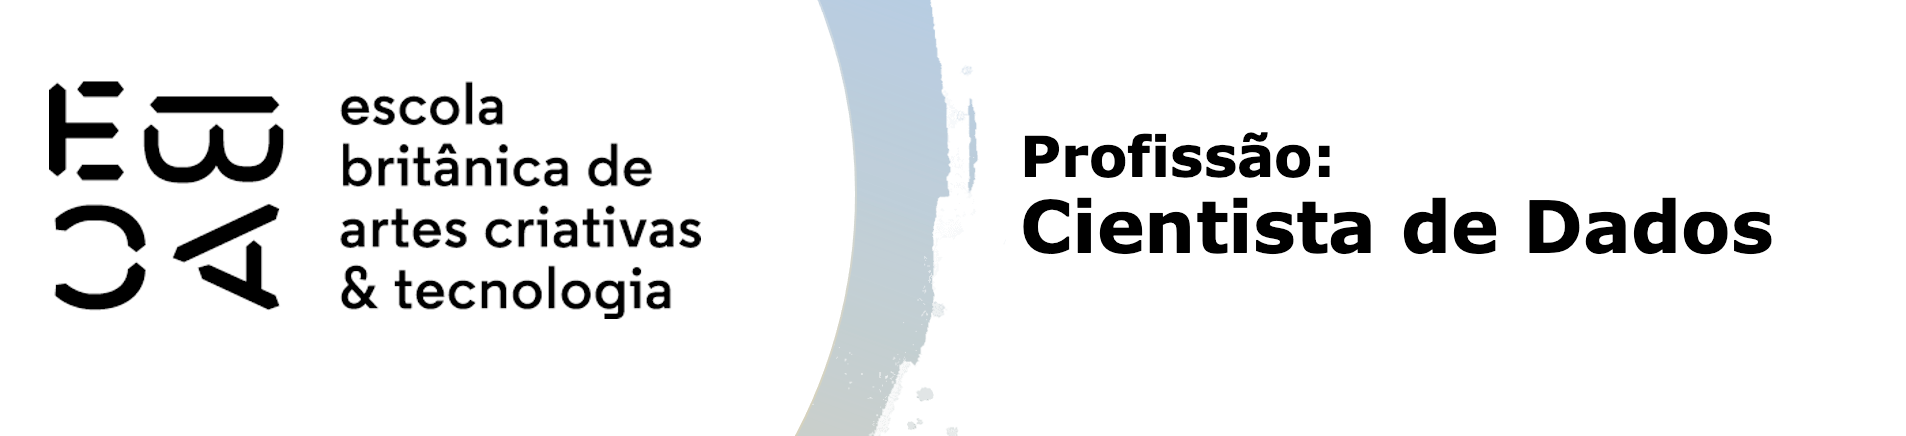

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering

import scipy.cluster.hierarchy as shc

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from gower import gower_matrix
from scipy.spatial.distance import pdist, squareform

from sklearn.decomposition import PCA

In [65]:
df = pd.read_csv('online_shoppers_intention.csv')

In [66]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [67]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [68]:
# Verificar valores ausentes
missing_values = df.isnull().sum()
print("Valores ausentes por coluna:")
print(missing_values)

Valores ausentes por coluna:
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [69]:
def perfil_colunas(df, nome):
    # Seleciona apenas as colunas numéricas
    df_numerico = df.select_dtypes(include='number')
    
    # Calcula estatísticas descritivas para cada coluna
    perfil = df_numerico.agg(['mean', 'std']).T  # Transpor para melhor visualização

    print(f"\nPerfil das Colunas Numéricas ({nome}):\n")
    display(perfil)

# Exemplo de uso
perfil_colunas(df, "Dados de Sessões Online")


Perfil das Colunas Numéricas (Dados de Sessões Online):



,mean,std
Administrative,2.315166,3.321784
Administrative_Duration,80.818611,176.779107
Informational,0.503569,1.270156
Informational_Duration,34.472398,140.749294
ProductRelated,31.731468,44.475503
ProductRelated_Duration,1194.746220,1913.669288
BounceRates,0.022191,0.048488
ExitRates,0.043073,0.048597
PageValues,5.889258,18.568437
SpecialDay,0.061427,0.198917


In [70]:
def perfil_categoricas(df, nome):
    """
    Exibe a distribuição das variáveis categóricas de forma organizada.
    """
    # Seleciona as colunas categóricas
    categorical_columns = df.select_dtypes(include=['object', 'bool']).columns
    
    print(f"\nPerfil das Variáveis Categóricas ({nome}):\n")
    
    for col in categorical_columns:
        print(f"\n{col}:\n")
        display(df[col].value_counts().to_frame(name='Frequência'))

# Exemplo de uso
perfil_categoricas(df, "Dados de Sessões Online")


Perfil das Variáveis Categóricas (Dados de Sessões Online):


Month:



,Frequência
Month,
May,3364
Nov,2998
Mar,1907
Dec,1727
Oct,549
Sep,448
Aug,433
Jul,432
June,288



VisitorType:



,Frequência
VisitorType,
Returning_Visitor,10551
New_Visitor,1694
Other,85



Weekend:



,Frequência
Weekend,
False,9462
True,2868



Revenue:



,Frequência
Revenue,
False,10422
True,1908


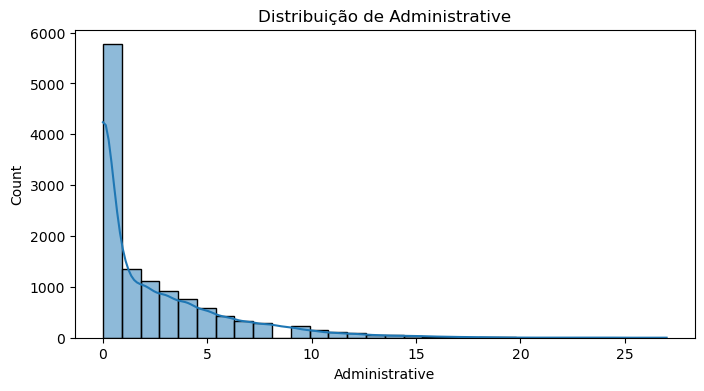

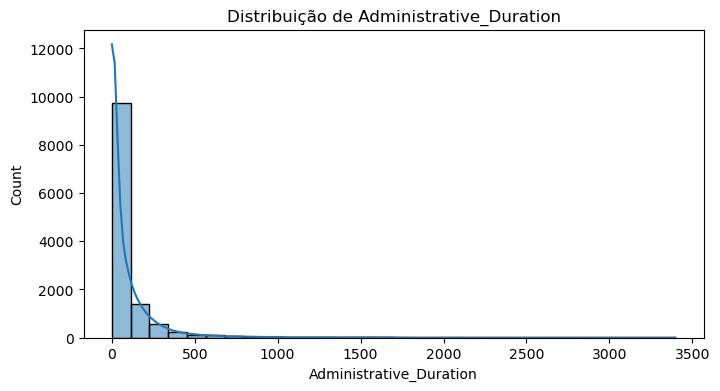

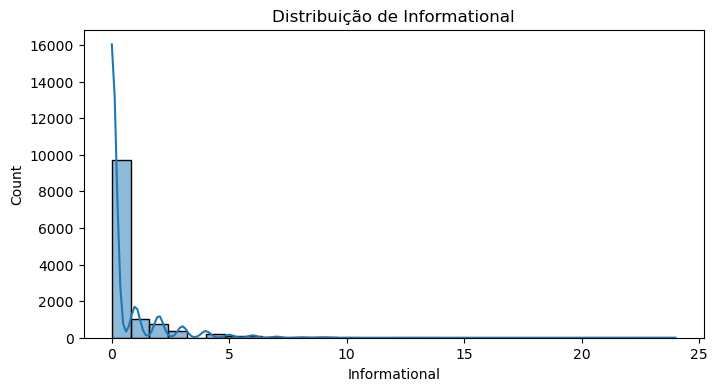

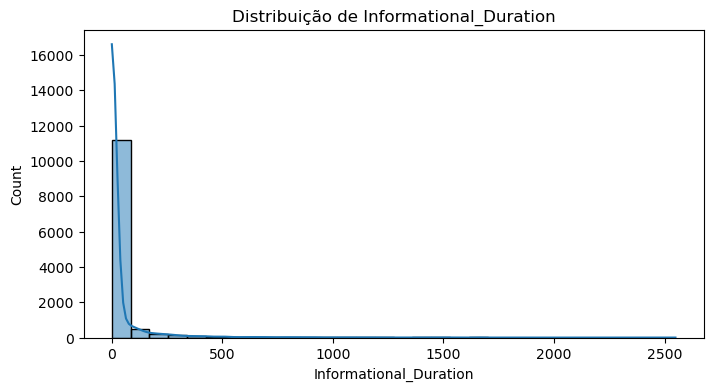

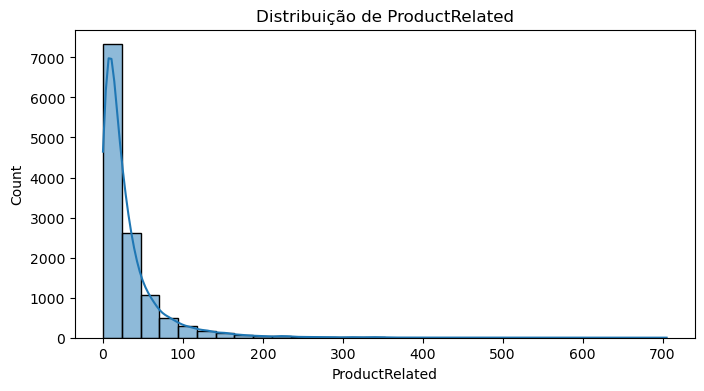

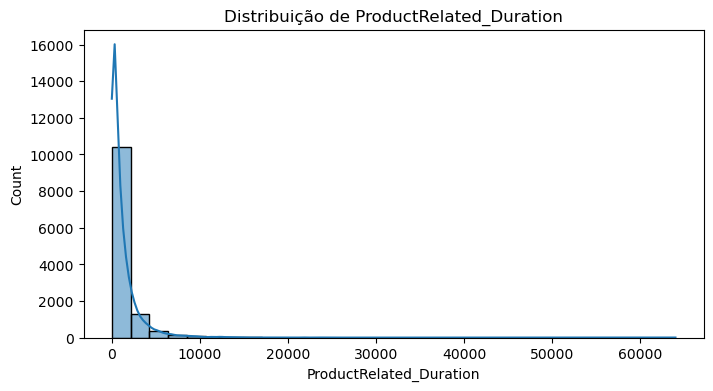

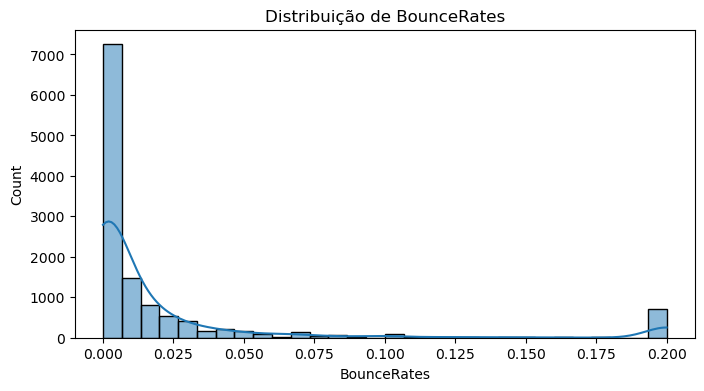

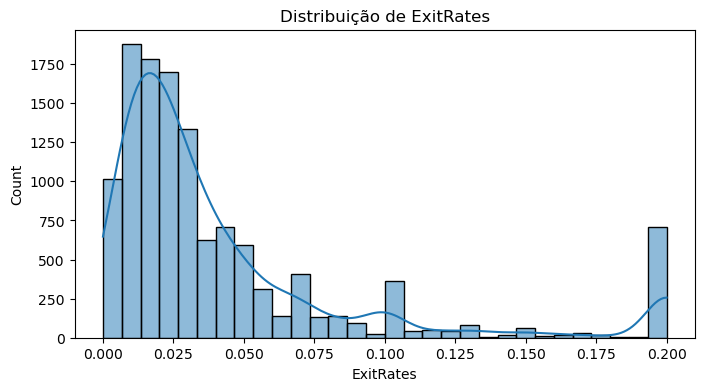

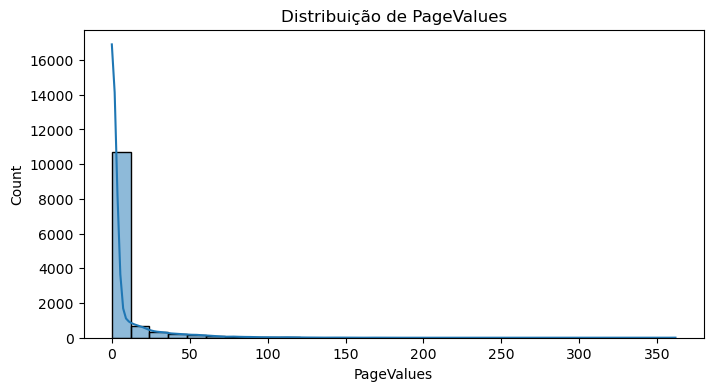

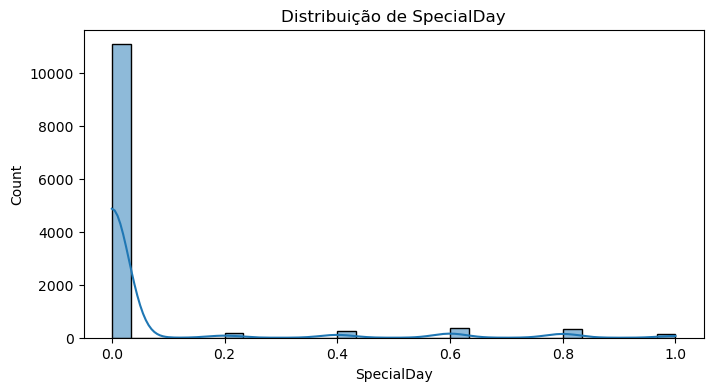

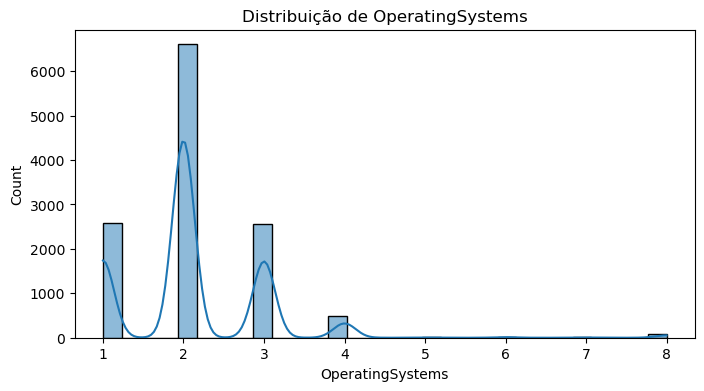

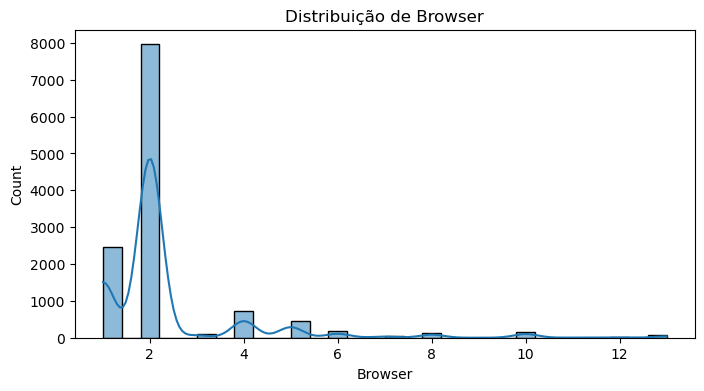

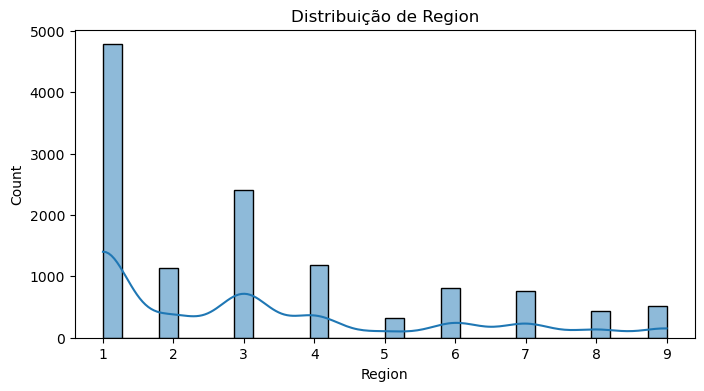

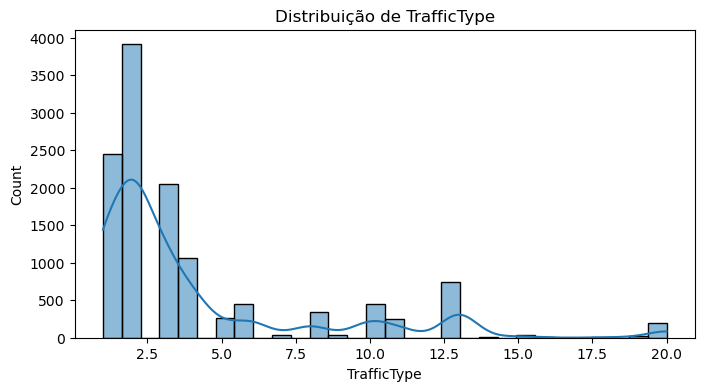

In [71]:
# Visualizar a distribuição das variáveis numéricas
import matplotlib.pyplot as plt

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribuição de {col}")
    plt.show()

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

Para realizar o agrupamento, vamos utilizar as seguintes variáveis com base nos critérios fornecidos:

1- Variáveis que descrevem o padrão de navegação na sessão:
- `Administrative`
- `Administrative_Duration`
- `Informational`
- `Informational_Duration`
- `ProductRelated`
- `ProductRelated_Duration`
- `BounceRates`
- `ExitRates`
- `PageValues`

2- Variáveis que indicam a característica da data:
- `SpecialDay`
- `Month` (Qualitativa)
- `Weekend` (Qualitativa)

In [72]:
# 1. Variáveis
vars_navegacao = [
    'Administrative', 'Administrative_Duration', 
    'Informational', 'Informational_Duration',
    'ProductRelated', 'ProductRelated_Duration', 
    'BounceRates', 'ExitRates', 'PageValues'
]

vars_data_qualitativas = ['Month', 'Weekend']
vars_data_numericas = ['SpecialDay']

# Subset do dataframe
df_sub = df[vars_navegacao + vars_data_numericas + vars_data_qualitativas].copy()

# 2. Tratamento de missing
df_sub[vars_navegacao + vars_data_numericas] = df_sub[vars_navegacao + vars_data_numericas].fillna(df_sub.mean(numeric_only=True))
df_sub[vars_data_qualitativas] = df_sub[vars_data_qualitativas].fillna(df_sub[vars_data_qualitativas].mode().iloc[0])

# 3. Padronizar as variáveis numéricas
scaler = StandardScaler()
dados_numericos = scaler.fit_transform(df_sub[vars_navegacao + vars_data_numericas])
df_numerico = pd.DataFrame(dados_numericos, columns=vars_navegacao + vars_data_numericas, index=df_sub.index)

# 4. Transformar qualitativas em dummies
df_dummies = pd.get_dummies(df_sub[vars_data_qualitativas], drop_first=False)

# 5. Juntar tudo
df_final = pd.concat([df_numerico, df_dummies], axis=1)

# df_final pronto para usar em clusterização
print(df_final.shape)
print(df_final.columns)
display(df_final.head())

(12330, 21)
Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
       'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep'],
      dtype='object')


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,False,False,True,False,False,False,False,False,False,False
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,...,False,False,True,False,False,False,False,False,False,False
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,False,False,True,False,False,False,False,False,False,False
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,...,False,False,True,False,False,False,False,False,False,False
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,...,False,False,True,False,False,False,False,False,False,False


## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

Calculando distâncias Gower...

Treinando o agrupamento...

Dividindo em 3 clusters...


<Figure size 2000x2000 with 0 Axes>

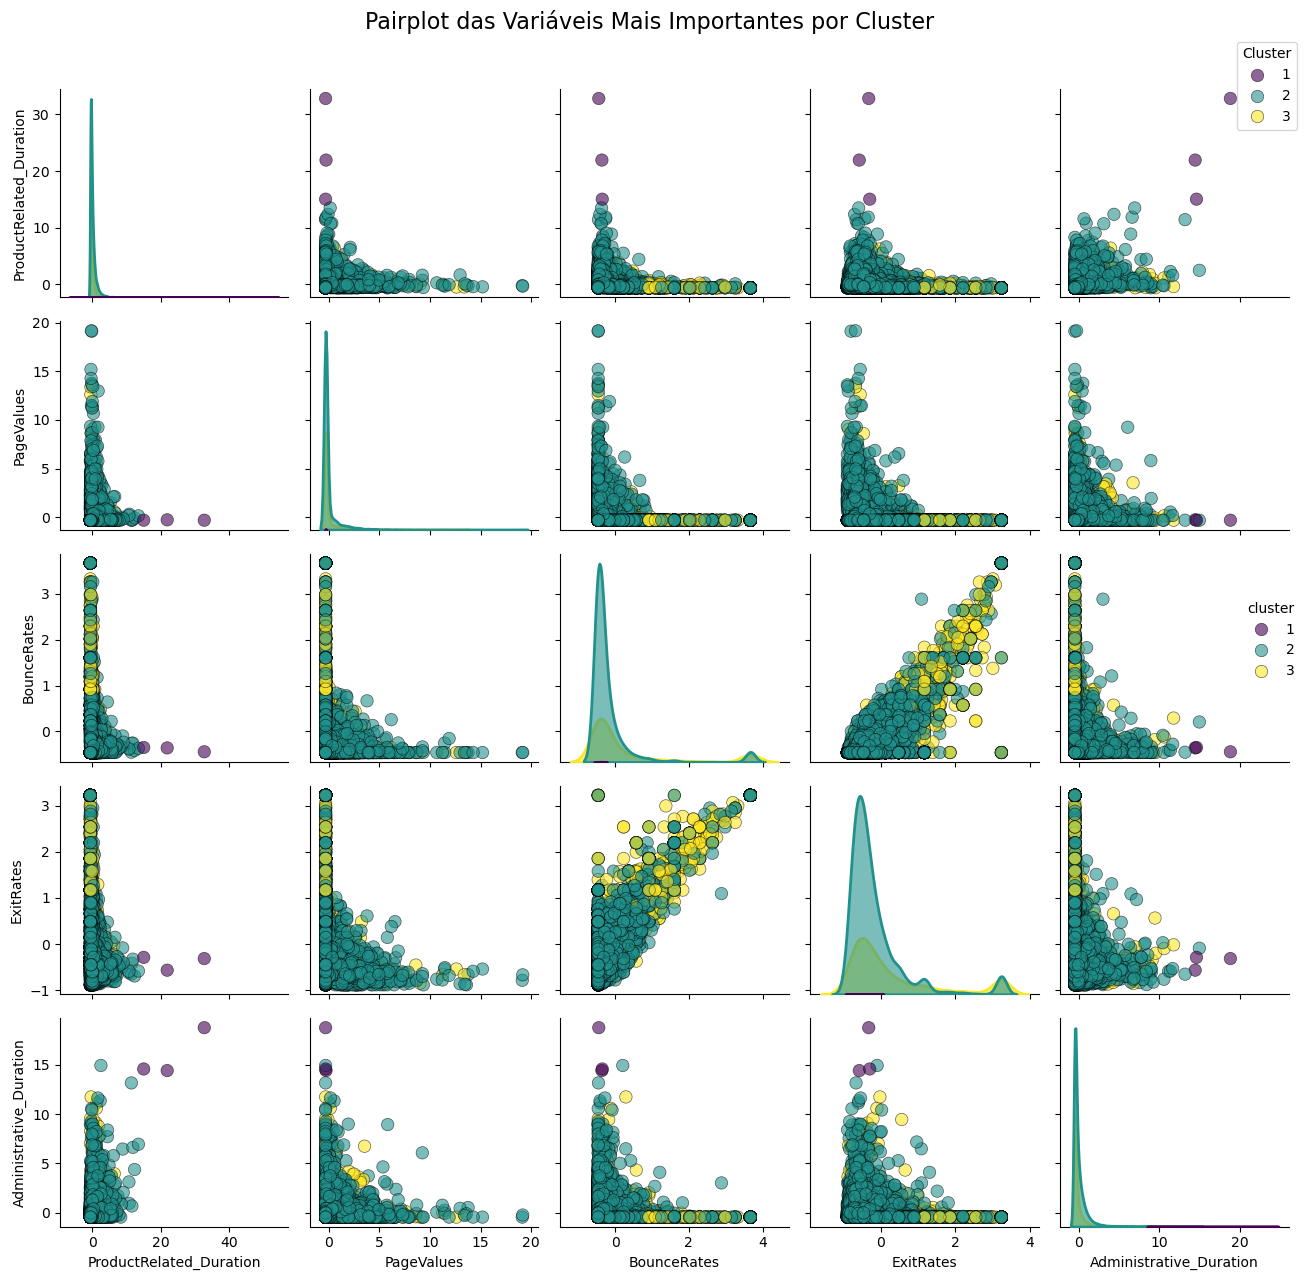


Perfil dos Clusters (Navegação Online de Compradores - 3 Clusters):



cluster,1,2,3
Tamanho do Cluster,3,8505,3822


cluster                               1         2         3
Administrative          mean   3.016022  0.074707 -0.168610
                        std    1.935514  1.039806  0.877858
Administrative_Duration mean  15.920450  0.043702 -0.109746
                        std    2.468678  1.013240  0.850585
Informational           mean  10.888679  0.042968 -0.104162
                        std    7.144112  1.041041  0.824691
Informational_Duration  mean  15.265486  0.029692 -0.078056
                        std    2.282959  1.047315  0.769396
ProductRelated          mean  10.506626  0.074797 -0.174691
                        std    4.184664  1.087116  0.676636
ProductRelated_Duration mean  23.260097  0.064915 -0.162711
                        std    8.958314  1.013953  0.660394
BounceRates             mean  -0.382531 -0.136466  0.303975
                        std    0.051653  0.791871  1.302816
ExitRates               mean  -0.391775 -0.145267  0.323566
                        std    0.153877  0.825591  1.248244
PageValues              mean  -0.303465  0.025904 -0.057406
                        std    0.023751  1.060973  0.846623
SpecialDay              mean  -0.308821 -0.308821  0.687455
                        std    0.000000  0.000000  1.594312

In [73]:
# Identificar variáveis categóricas (dummies)
# Criar uma lista de booleanos onde True representa variáveis categóricas
vars_cat = [True if col.startswith('Month_') or col.startswith('Weekend') else False for col in df_final.columns]

# Calcular distância de Gower
print("Calculando distâncias Gower...")
distancia_gower = gower_matrix(df_final, cat_features=vars_cat)

# Converter para formato adequado para o linkage
gdv = squareform(distancia_gower, force='tovector')

# Aplicar o algoritmo de linkage sem visualizar o dendrograma
print("\nTreinando o agrupamento...")
Z = linkage(gdv, method='complete')

# Dividir em 3 clusters
print("\nDividindo em 3 clusters...")
clusters = fcluster(Z, 3, criterion='maxclust')

# Adicionar cluster ao dataframe original
df_final['cluster'] = clusters

# Visualizando algumas variáveis no pairplot
vars_importantes = [
    'ProductRelated_Duration', 
    'PageValues', 
    'BounceRates', 
    'ExitRates', 
    'Administrative_Duration'
    ]
# Criar DataFrame para o pairplot
df_pair = df_final[vars_importantes].copy()
df_pair['cluster'] = df_final['cluster']  # Adicionar informação do cluster

# Criar o pairplot
plt.figure(figsize=(20, 20))
pair_plot = sns.pairplot(
    df_pair, 
    hue='cluster',  # Colorir por cluster
    diag_kind='kde',  # Usar KDE nas diagonais
    plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k', 'linewidth': 0.5},
    diag_kws={'alpha': 0.6, 'linewidth': 2},
    palette='viridis',  # Esquema de cores
    height=2.5  # Tamanho de cada subplot
)

# Ajustar o título
pair_plot.fig.suptitle('Pairplot das Variáveis Mais Importantes por Cluster', y=1.02, fontsize=16)

# Melhorar a legenda
handles = pair_plot._legend_data.values()
labels = pair_plot._legend_data.keys()
pair_plot.fig.legend(handles, labels, loc='upper right', title='Cluster', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()
def perfil_clusters(df, nome_analise, coluna_cluster='cluster', exibir_std=True):

    # Cria uma cópia do DataFrame para não modificar o original
    df_copy = df.copy()
    
    # Seleciona apenas as colunas numéricas (exclui strings)
    df_numerico = df_copy.select_dtypes(include='number')
    
    # Garante que a coluna de cluster esteja presente
    if coluna_cluster not in df_numerico.columns:
        raise ValueError(f"Coluna '{coluna_cluster}' não encontrada no DataFrame")
    
    # Calcular tamanho de cada cluster
    tamanho_cluster = df_numerico[coluna_cluster].value_counts().sort_index()
    tamanho_cluster = tamanho_cluster.rename("Tamanho do Cluster").to_frame().T
    
    # Calcular estatísticas descritivas por cluster
    if exibir_std:
        perfil = df_numerico.groupby(coluna_cluster).agg(['mean', 'std']).T
    else:
        perfil = df_numerico.groupby(coluna_cluster).agg(['mean']).T
    
    # Exibir resultados
    print(f"\nPerfil dos Clusters ({nome_analise}):\n")
    display(tamanho_cluster)
    display(perfil)
    
    return perfil

# Usar a função para visualizar o perfil dos clusters
perfil = perfil_clusters(df_final, "Navegação Online de Compradores - 3 Clusters")

Calculando distâncias Gower...

Treinando o agrupamento...

Dividindo em 4 clusters...


<Figure size 2000x2000 with 0 Axes>

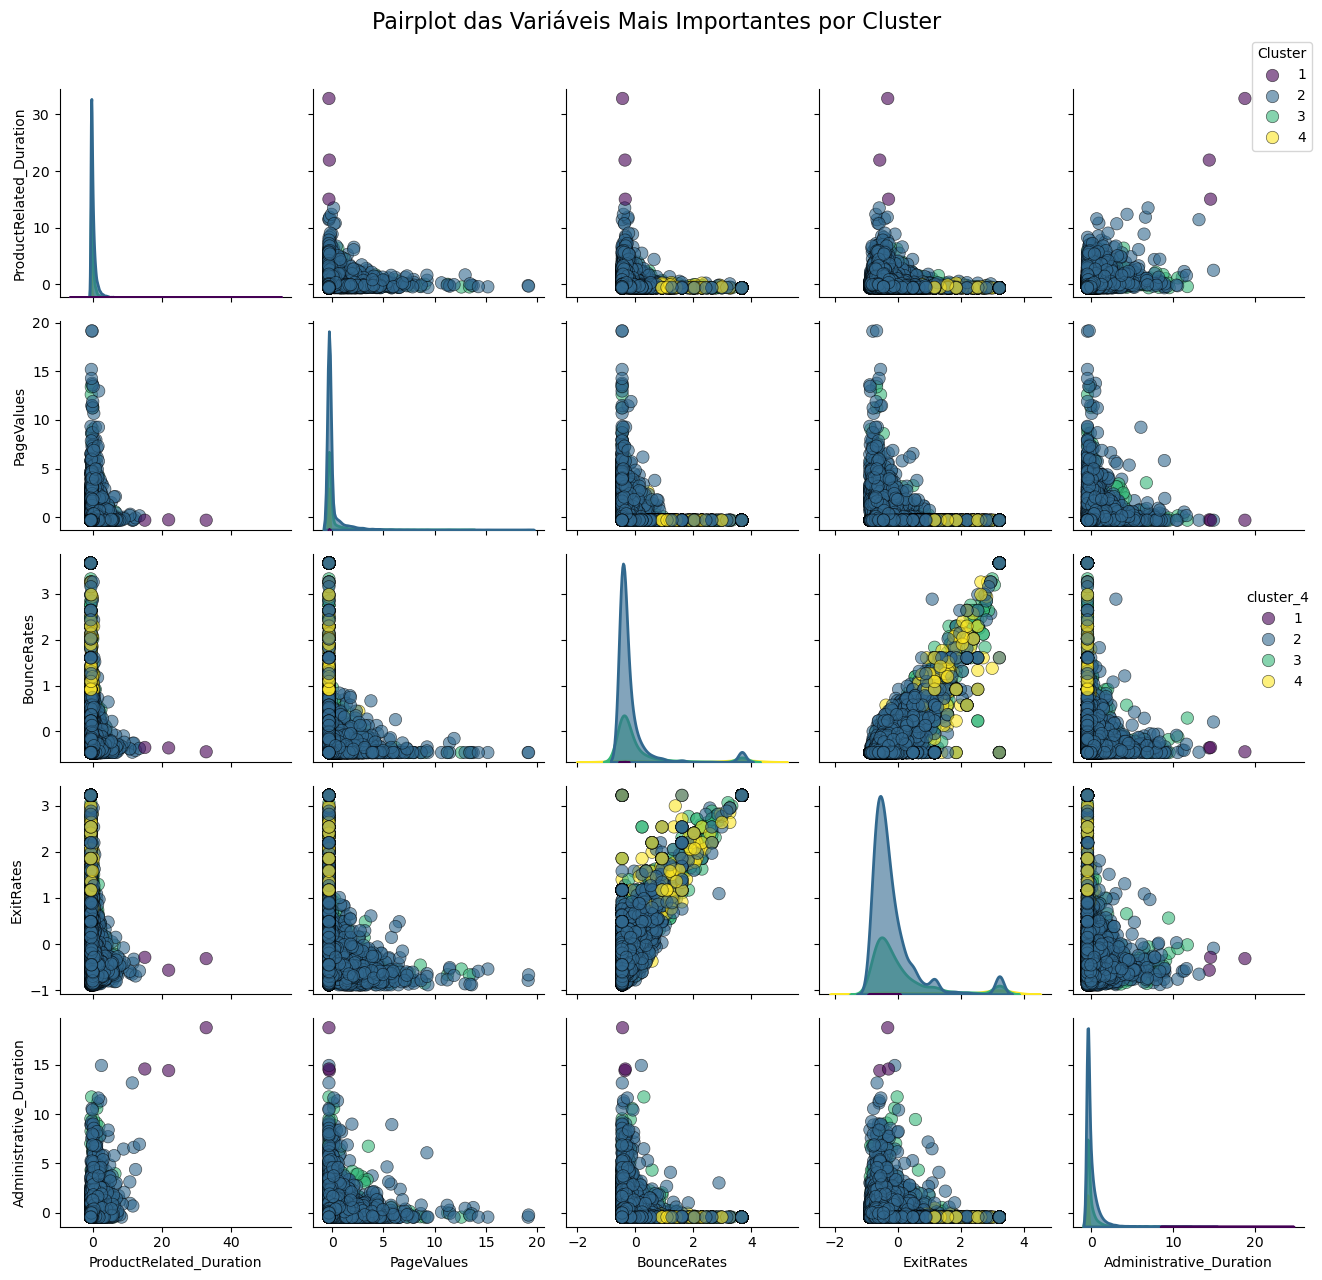


Perfil dos Clusters (Navegação Online de Compradores - 4 Clusters):



cluster,1,2,3
Tamanho do Cluster,3,8505,3822


cluster                               1         2         3
Administrative          mean   3.016022  0.074707 -0.168610
                        std    1.935514  1.039806  0.877858
Administrative_Duration mean  15.920450  0.043702 -0.109746
                        std    2.468678  1.013240  0.850585
Informational           mean  10.888679  0.042968 -0.104162
                        std    7.144112  1.041041  0.824691
Informational_Duration  mean  15.265486  0.029692 -0.078056
                        std    2.282959  1.047315  0.769396
ProductRelated          mean  10.506626  0.074797 -0.174691
                        std    4.184664  1.087116  0.676636
ProductRelated_Duration mean  23.260097  0.064915 -0.162711
                        std    8.958314  1.013953  0.660394
BounceRates             mean  -0.382531 -0.136466  0.303975
                        std    0.051653  0.791871  1.302816
ExitRates               mean  -0.391775 -0.145267  0.323566
                        std    0.153877  0.825591  1.248244
PageValues              mean  -0.303465  0.025904 -0.057406
                        std    0.023751  1.060973  0.846623
SpecialDay              mean  -0.308821 -0.308821  0.687455
                        std    0.000000  0.000000  1.594312
cluster_4               mean   1.000000  2.000000  3.120094
                        std    0.000000  0.000000  0.325114

In [74]:
# Identificar variáveis categóricas (dummies)
# Criar uma lista de booleanos onde True representa variáveis categóricas
vars_cat = [True if col.startswith('Month_') or col.startswith('Weekend') else False for col in df_final.columns]

# Calcular distância de Gower
print("Calculando distâncias Gower...")
distancia_gower = gower_matrix(df_final, cat_features=vars_cat)

# Converter para formato adequado para o linkage
gdv = squareform(distancia_gower, force='tovector')

# Aplicar o algoritmo de linkage sem visualizar o dendrograma
print("\nTreinando o agrupamento...")
Z = linkage(gdv, method='complete')

# Dividir em 3 clusters
print("\nDividindo em 4 clusters...")
clusters = fcluster(Z, 4, criterion='maxclust')

# Adicionar cluster ao dataframe original
df_final['cluster_4'] = clusters

# Visualizando algumas variáveis no pairplot
vars_importantes = [
    'ProductRelated_Duration', 
    'PageValues', 
    'BounceRates', 
    'ExitRates', 
    'Administrative_Duration'
]

# Criar DataFrame para o pairplot
df_pair = df_final[vars_importantes].copy()
df_pair['cluster_4'] = df_final['cluster_4']  # Adicionar informação do cluster

# Criar o pairplot
plt.figure(figsize=(20, 20))
pair_plot = sns.pairplot(
    df_pair, 
    hue='cluster_4',  # Colorir por cluster
    diag_kind='kde',  # Usar KDE nas diagonais
    plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k', 'linewidth': 0.5},
    diag_kws={'alpha': 0.6, 'linewidth': 2},
    palette='viridis',  # Esquema de cores
    height=2.5  # Tamanho de cada subplot
)

# Ajustar o título
pair_plot.fig.suptitle('Pairplot das Variáveis Mais Importantes por Cluster', y=1.02, fontsize=16)

# Melhorar a legenda
handles = pair_plot._legend_data.values()
labels = pair_plot._legend_data.keys()
pair_plot.fig.legend(handles, labels, loc='upper right', title='Cluster', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

# Usar a função para visualizar o perfil dos clusters
perfil = perfil_clusters(df_final, "Navegação Online de Compradores - 4 Clusters")

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [87]:
tamanho_cluster = df_final['cluster'].value_counts().sort_index()
tamanho_cluster = tamanho_cluster.rename("Tamanho do Cluster").to_frame().T
print(tamanho_cluster)

# Cruzar cluster e Revenue (1 = comprou, 0 = não comprou)
proporcao_compras = pd.crosstab(df['Revenue'], df_final['cluster'], normalize='columns').round(3) * 100

print("Proporção de Compradores por Cluster (%) - 3 Grupos:")
display(proporcao_compras)

tamanho_cluster_4 = df_final['cluster_4'].value_counts().sort_index()
tamanho_cluster_4 = tamanho_cluster_4.rename("Tamanho do Cluster").to_frame().T
print(tamanho_cluster_4)

# Cruzar cluster e Revenue (1 = comprou, 0 = não comprou)
proporcao_compras_4 = pd.crosstab(df['Revenue'], df_final['cluster_4'], normalize='columns').round(3) * 100

print("Proporção de Compradores por Cluster (%) - 4 Grupos:")
display(proporcao_compras_4)


cluster             1     2     3
Tamanho do Cluster  3  8505  3822
Proporção de Compradores por Cluster (%) - 3 Grupos:


cluster,1,2,3
Revenue,,,
False,100.0,81.9,90.4
True,0.0,18.1,9.6


cluster_4           1     2     3    4
Tamanho do Cluster  3  8505  3363  459
Proporção de Compradores por Cluster (%) - 4 Grupos:


cluster_4,1,2,3,4
Revenue,,,,
False,100.0,81.9,89.1,99.3
True,0.0,18.1,10.9,0.7


In [84]:
df_avaliacao = df_final.copy()
df_avaliacao['Revenue'] = df['Revenue']  # Adiciona a variável externa

# Estatísticas por cluster
stats_cluster = df_avaliacao.groupby('cluster')['BounceRates'].agg(['mean']).round(3)

stats_cluster_4 = df_avaliacao.groupby('cluster_4')['BounceRates'].agg(['mean']).round(3)
print("Média de Bounce Rates por Cluster - 3 Grupos:")
display(stats_cluster)
print("Média de Bounce Rates por Cluster - 4 Grupos:")
display(stats_cluster_4)


Média de Bounce Rates por Cluster - 3 Grupos:


,mean
cluster,
1,-0.383
2,-0.136
3,0.304


Média de Bounce Rates por Cluster - 4 Grupos:


,mean
cluster_4,
1,-0.383
2,-0.136
3,0.097
4,1.824


## Conclusão

Em ambos os casos, o cluster 1 ficou com uma quantidade muito pequena de usuários (apenas 3), e por isso iremos desconsiderá-lo das análises a seguir.


#### Análise com 3 Grupos
Distribuição dos clusters: O Cluster 2 é o maior (8.505 usuários), seguido pelo Cluster 3 (3.822).

Sobre taxa de rejeição média (BounceRates), o Cluster 3 possui um número maior, 0.304, contra -0.136 dos usuários no Cluster 2. Por outro lado, a taxa de conversão em compras do Cluster 2 é maior do que a do cluster 3 (18,1% contra 9,6%).

A partir disso, o Cluster 2 se destaca como o grupo mais promissor, com uma baixa taxa de rejeição e a maior taxa de conversão, enquanto o Cluster 3, apesar de ser relevante em tamanho, tem uma taxa de rejeição elevada e menor propensão à compra.


#### Análise com 4 Grupos
Distribuição dos clusters: O Cluster 2 continua sendo o maior (8.505), seguido pelo Cluster 3 (3.363) e pelo Cluster 4 (459).

Sobre taxa de rejeição média (BounceRates), o Cluster 4 possui um número bem maior que os demais, de 1.824, contra -0.136 dos usuários no Cluster 2 e 0.097 dos usuários no cluster 3.

Sobre a taxa de conversão em compras do Cluster 2 continua sendo a maior, com 18,1%, enquanto as taxas do cluster 3 ficou em 10,9% e a do cluster 4 com apenas 0,7%.

Observamos que o Cluster 2 permanece com o melhor desempenho em conversão, mantendo uma taxa de rejeição baixa. O Cluster 4, por outro lado, apresenta um comportamento típico de usuários com baixa interação e quase nenhuma conversão, evidenciado pela altíssima taxa de rejeição e taxa de compra de apenas 0,7%.

#### Conclusão Geral

A introdução de mais clusters nos permite identificar subgrupos com características distintas de navegação:

O Cluster 2 (em ambos os cenários) representa o grupo mais propenso à compra, combinando uma taxa de rejeição controlada e a maior conversão.

O Cluster 3 tende a representar um grupo engajado em navegação, mas menos eficiente em conversão, sugerindo que pode haver interesse, mas barreiras na finalização da compra.

O Cluster 4 no modelo com 4 grupos destaca um público muito pouco engajado, provavelmente composto por visitas acidentais ou desinteressadas.

O Cluster 1, embora presente, é pequeno demais para conclusões relevantes neste caso.

Essa análise reforça a importância de segmentar os usuários com base em dados, permitindo identificar perfis que devem ser priorizados em estratégias de marketing ou personalização da experiência no site.